# Final Project: Load balancing

Léo Meissner & Héloïse Lafargue, 3A SN IMM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

## 1 MDP

###1.1 Policy Evaluation

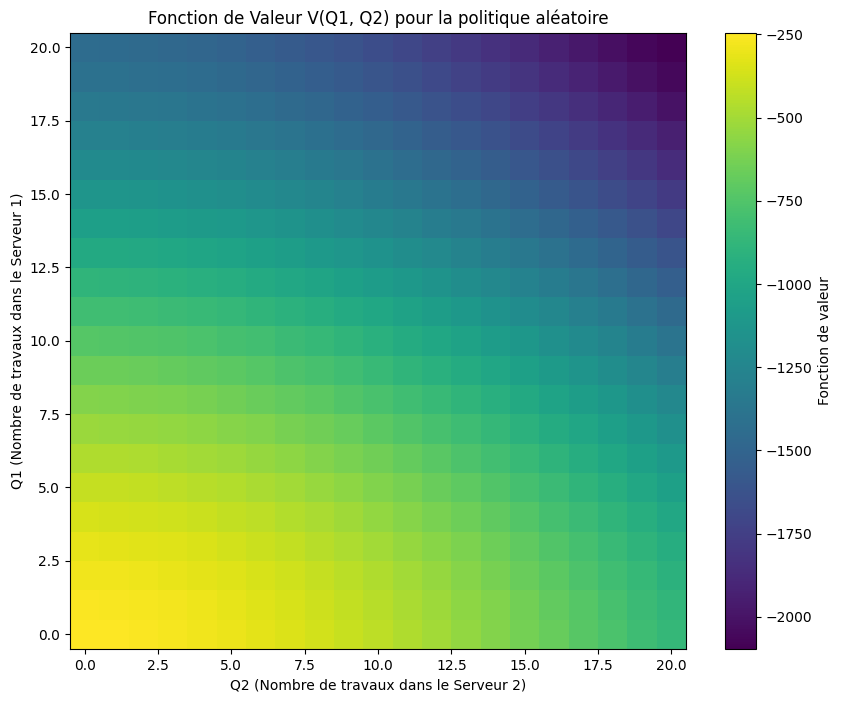

In [ ]:
# Paramètres
mu1 = 0.2
mu2 = 0.4
lbda = 0.3
gamma = 0.99
delta_threshold = 0.01
max_Q = 20

# Initialiser la fonction de valeur V(Q1, Q2)
# Les états (Q1,Q2) vont de de 0 à 20 chacuns
V = np.zeros((max_Q + 1, max_Q + 1)) # Selon le principe de contraction, le vecteur initial peut être arbitraire : V (Q1, Q2) = 0, for all (Q1, Q2).

# Fonction pour calculer les probabilités d'état suivant et les récompenses
def next_state_prob_reward(Q1, Q2, action):
    transitions = []
    reward = -(Q1 + Q2)

    # Arrivée d'un travail
    # Arrivée dans le serveur courant, sauf si un des serveurs est déjà plein, remplir l'autre
    if not (Q1 == max_Q and Q2 == max_Q):
        if Q1 == max_Q :
          new_Q1, new_Q2 = Q1, Q2 + 1
        elif Q2 == max_Q :
          new_Q1, new_Q2 = Q1 + 1, Q2
        else :
          new_Q1, new_Q2 = (Q1 + 1, Q2) if action == 'a1' else (Q1, Q2 + 1)
        transitions.append((lbda, (new_Q1, new_Q2), reward))
    else :
      transitions.append((lbda, (Q1, Q2), reward))

    # Départ du serveur 1
    if Q1 > 0:
        transitions.append((mu1, (Q1 - 1, Q2), reward))

    # Départ du serveur 2
    if Q2 > 0:
        transitions.append((mu2, (Q1, Q2 - 1), reward))

    # Aucune arrivée ou départ
    no_event_prob = 1 - lbda - (mu1 if Q1 > 0 else 0) - (mu2 if Q2 > 0 else 0)
    transitions.append((no_event_prob, (Q1, Q2), reward))

    return transitions

# Évaluation de la politique itérative
while True:
    delta = 0
    new_V = np.zeros_like(V)
    for Q1 in range(max_Q + 1):
        for Q2 in range(max_Q + 1):
            v = 0
            v1, v2 = 0, 0
            reward = -(Q1 + Q2)
            transitions_1 = next_state_prob_reward(Q1, Q2, 'a1')
            transitions_2 = next_state_prob_reward(Q1, Q2, 'a2')
            for prob, (new_Q1, new_Q2), _ in transitions_1:
                v1 += prob * V[new_Q1, new_Q2]
            v1_final = reward + gamma * v1
            for prob, (new_Q1, new_Q2), _ in transitions_2:
                v2 += prob * V[new_Q1, new_Q2]
            v2_final = reward + gamma * v2
            v = 0.5 * v1_final + 0.5 * v2_final
            new_V[Q1, Q2] = v
            # Critère d'arrêt
            delta = max(delta, abs(v - V[Q1, Q2]))
    V = new_V
    if delta < delta_threshold:
        break

plt.figure(figsize=(10, 8))
plt.imshow(V, interpolation='nearest')
plt.colorbar(label='Fonction de valeur')
plt.title('Fonction de Valeur V(Q1, Q2) pour la politique aléatoire')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()
plt.show()

The value function V(Q1, Q2) represents the expected value of each state based on the server capacities.
The graph demonstrates a decrease in V(Q1, Q2) as both Q1 and Q2 increase, indicating a declining trend in the value of states. As the servers' workload intensifies, the value becomes more negative, illustrating the amplified cost or penalty linked with larger queues or a higher number of pending jobs awaiting processing. "The rapid decline in value for Q2 suggests a swifter reduction in the second server's capacity. This pattern corresponds to the scenario where $\mu_2 > \mu_1$, indicating a higher departure rate from the second server.

### 1.2 Optimal control

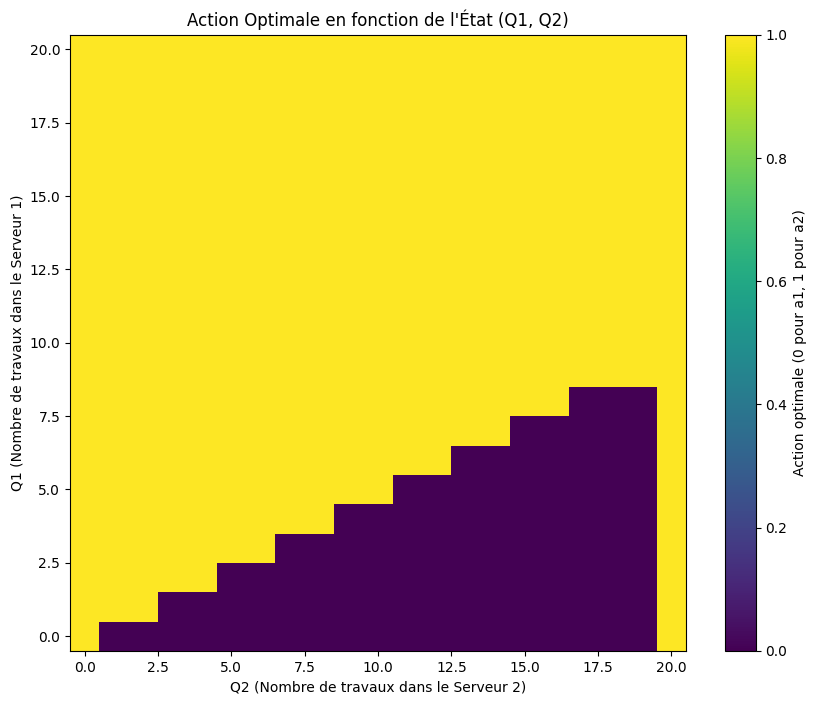

In [ ]:
# Initialiser la fonction de valeur optimale V(Q1, Q2)
optimal_V = np.zeros((max_Q + 1, max_Q + 1))  # Selon le principe de contraction, le vecteur initial peut être arbitraire

# Fonction pour calculer l'état suivant et la récompense en fonction de l'état actuel et de l'action
# (identique à celle précédemment utilisée)

delta_threshold = 0.01

# Algorithme d'itération de la valeur pour trouver la fonction de valeur optimale V
while True :
    delta = 0
    new_V = np.zeros_like(optimal_V)
    for Q1 in range(max_Q + 1):
        for Q2 in range(max_Q + 1):
            v = 0
            v1, v2 = 0, 0
            reward = -(Q1 + Q2)
            transitions_1 = next_state_prob_reward(Q1, Q2, 'a1')
            transitions_2 = next_state_prob_reward(Q1, Q2, 'a2')
            for prob, (new_Q1, new_Q2), _ in transitions_1:
                v1 += prob * optimal_V[new_Q1, new_Q2]
            v1_final = reward + gamma * v1
            for prob, (new_Q1, new_Q2), _ in transitions_2:
                v2 += prob * optimal_V[new_Q1, new_Q2]
            v2_final = reward + gamma * v2
            v = max(v1_final, v2_final)
            new_V[Q1, Q2] = v
            # Critère d'arrêt
            delta = max(delta, abs(v - optimal_V[Q1, Q2]))
    optimal_V = new_V
    if delta < delta_threshold:
        break

def action_optimale(Q1, Q2):
    v1, v2 = 0, 0
    reward = -(Q1 + Q2)
    transitions_1 = next_state_prob_reward(Q1, Q2, 'a1')
    transitions_2 = next_state_prob_reward(Q1, Q2, 'a2')
    for prob, (new_Q1, new_Q2), _ in transitions_1:
        v1 += prob * optimal_V[new_Q1, new_Q2]
    v1_final = reward + gamma * v1
    for prob, (new_Q1, new_Q2), _ in transitions_2:
        v2 += prob * optimal_V[new_Q1, new_Q2]
    v2_final = reward + gamma * v2
    best_action = (1 if v1_final <= v2_final else 0)

    return best_action

# Représentation de l'action optimale en fonction de l'état (Q1, Q2)
actions_optimales = np.zeros((max_Q + 1, max_Q + 1))
for Q1 in range(max_Q + 1):
    for Q2 in range(max_Q + 1):
        actions_optimales[Q1, Q2] = action_optimale(Q1, Q2)

# Affichage de l'action optimale en fonction de l'état (Q1, Q2)
plt.figure(figsize=(10, 8))
plt.imshow(actions_optimales, interpolation='nearest')
plt.colorbar(label='Action optimale (0 pour a1, 1 pour a2)')
plt.title('Action Optimale en fonction de l\'État (Q1, Q2)')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()

In the graph representing actions under the optimal policy, a clear trend is observed where the predominant action is '$a_2$' (dispatch a potential new incoming job to server Q2). The trend of stepped structure for for '$a_1$' signifies an initial equilibrium in action preference, gradually shifting towards favoring '$a_2$' as both Q1 and Q2 become more occupied. This behavior underscores a tendency to prioritize  '$a_2$', likely due to the higher departure rate from Q2, aligning with the system's dynamics.


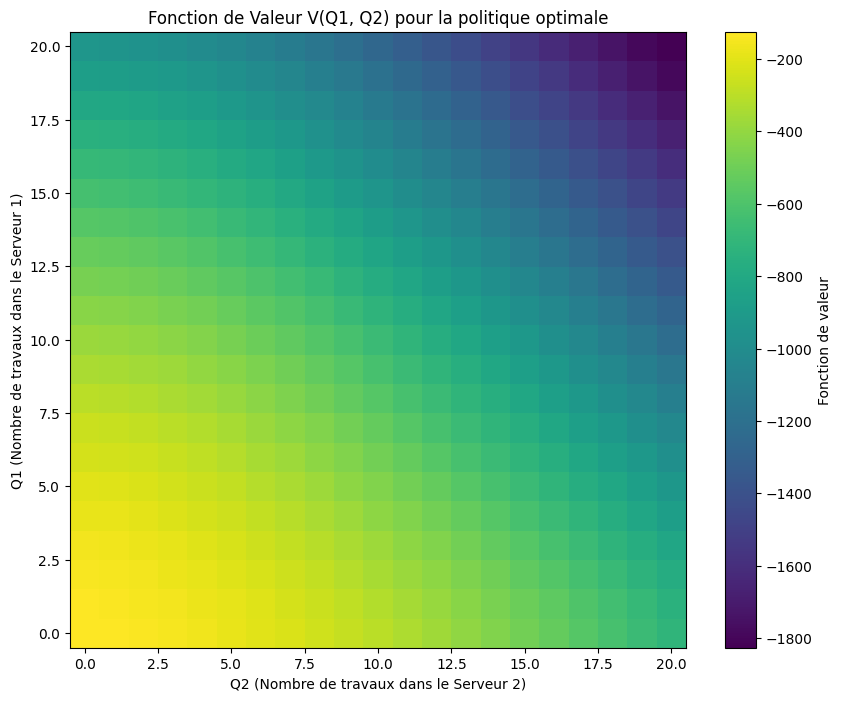

In [ ]:
# Affichage de la fonction de valeur
plt.figure(figsize=(10, 8))
plt.imshow(optimal_V, interpolation='nearest')
plt.colorbar(label='Fonction de valeur')
plt.title('Fonction de Valeur V(Q1, Q2) pour la politique optimale')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()

**Comparison between Random Policy and Optimal Policy** :

- **Random Policy**: This policy assigns an equal probability to each job to be sent to either of the servers, without considering the current load on the servers or the available capacity. It may not optimize the utilization of available resources and may not balance the load effectively.

- **Optimal Policy**: The optimal policy is one that takes into account the current load on the servers when making decisions about the assignment of new jobs. It aims to maximize the cumulative value of states while considering the servers' capacities.


• In the figure, there is a comparison of the performances obtained with the policies.
    
We simulated both the Random Policy and the Optimal Policy using the ServerEnvironment over 100,000 iterations. The average number of jobs observed under the Random Policy was 3.53239, while under the Optimal Policy, it decreased significantly to 1.3703. This difference in the average number of jobs can be attributed to the efficiency in job handling.


The Random Policy tends to generate a higher number of jobs on average compared to the Optimal Policy. This outcome signifies a more effective management and distribution of jobs under the Optimal Policy, resulting in a reduced workload and better server utilization. The Optimal Policy demonstrates a more balanced and efficient approach, leading to a lower average number of jobs over time compared to the Random Policy.

To conclude, the optimal policy performs better than the random policy. The optimal policy manages to distribute the load efficiently between servers and maintain a balance between capacity and demand.


In [ ]:
class ServerEnvironment:
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20):
        self.mu1 = mu1
        self.mu2 = mu2
        self.lbda = lambd
        self.max_Q = max_jobs
        self.Q1 = 0
        self.Q2 = 0

    def reset(self):
        self.Q1 = random.randint(0, self.max_Q)
        self.Q2 = random.randint(0, self.max_Q)

    def get_state(self):
        return (self.Q1, self.Q2)

    def step(self, action):
        crit = random.random()
        miss = False

        if crit < self.mu1:  # Départ dans Q1
            new_Q1 = max(0, self.Q1 - 1)
            new_Q2 = self.Q2
        elif (crit >= self.mu1) and (crit < self.mu1 + self.mu2):  # Départ dans Q2
            new_Q1 = self.Q1
            new_Q2 = max(0, self.Q2 - 1)
        elif (crit >= self.mu1 + self.mu2) and (crit < self.mu1 + self.mu2 + self.lbda): # Arrivée
            if self.Q1 == self.max_Q and self.Q2 == self.max_Q:
                miss = True
            if not (self.Q1 == self.max_Q and self.Q2 == self.max_Q):
                if self.Q1 == self.max_Q : # si Q1 est plein, arrivée dans Q2
                    new_Q1 = self.Q1
                    new_Q2 = self.Q2 + 1
                elif self.Q2 == self.max_Q : # si Q2 est plein, arrivée dans Q1
                    new_Q1 = self.Q1 + 1
                    new_Q2 = self.Q2
                else:
                    if action == 'a1': # arrivée dans Q1
                        new_Q1 = self.Q1 + 1
                        new_Q2 = self.Q2
                    elif action == 'a2': # arruvée dans Q2
                        new_Q1 = self.Q1
                        new_Q2 = self.Q2 + 1
            else :
                new_Q1 = self.Q1
                new_Q2 = self.Q2
        else:  # Reste dans le même état
            new_Q1 = self.Q1
            new_Q2 = self.Q2

        self.Q1 = new_Q1
        self.Q2 = new_Q2
        reward = -(self.Q1 + self.Q2)

        # Return new state and cost
        return (self.Q1, self.Q2), reward, miss


In [ ]:
def run_policy(env, policy='random', nb_episodes=100000):
    comtpeur = 0
    nb_jobs_miss = 0
    jobs = []

    while comtpeur < nb_episodes:
        if policy == 'random':
            action = 'a1' if random.random() < 0.5 else 'a2'
        else:
            action = actions_optimales[env.Q1, env.Q2]
            action = 'a1' if action == 0 else 'a2'

        (new_Q1, new_Q2), reward, miss = env.step(action)

        if miss:
            nb_jobs_miss += 1

        nb_jobs = new_Q1 + new_Q2
        jobs.append(nb_jobs)
        comtpeur += 1

    return jobs, nb_jobs_miss / nb_episodes

Random Policy - Nombre de jobs moyen :  3.56667
Random Policy - Nombre de jobs manqués moyen :  0.0

Optimal Policy - Nombre de jobs moyen :  1.32501
Optimal Policy - Nombre de jobs manqués moyen :  0.0 



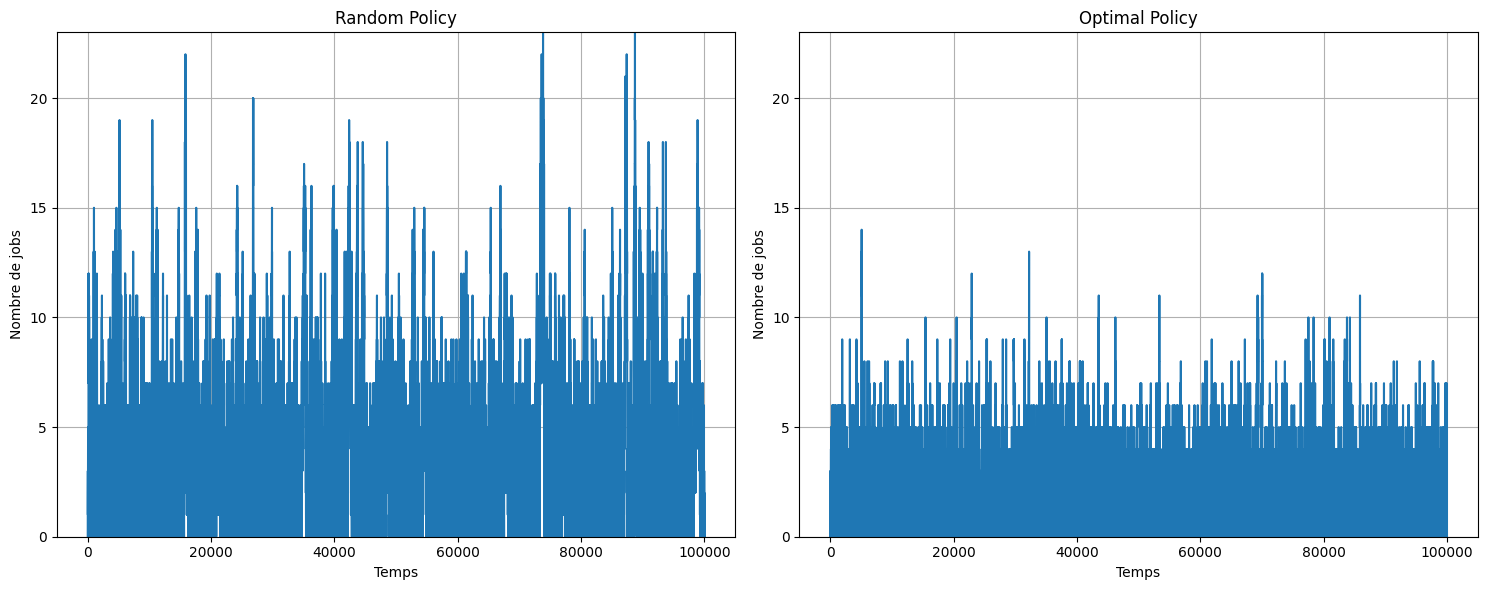

In [ ]:
env = ServerEnvironment()  # Initialiser l'environnement

# Exécuter avec la politique aléatoire
jobs_random, miss_rate_random = run_policy(env, policy='random')

# Exécuter avec la politique optimale
jobs_optimal, miss_rate_optimal = run_policy(env, policy='optimal')

# Affichage des statistiques
print("Random Policy - Nombre de jobs moyen : ", np.mean(jobs_random))
print("Random Policy - Nombre de jobs manqués moyen : ", miss_rate_random)

print("\nOptimal Policy - Nombre de jobs moyen : ", np.mean(jobs_optimal))
print("Optimal Policy - Nombre de jobs manqués moyen : ", miss_rate_optimal, '\n')

# Déterminer les limites pour l'axe y pour avoir la même échelle sur les deux graphiques
y_limit = max(max(jobs_random), max(jobs_optimal))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(jobs_random)
plt.title('Random Policy')
plt.xlabel('Temps')
plt.ylabel('Nombre de jobs')
plt.ylim(0, y_limit)  # Limite pour l'axe y
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(jobs_optimal)
plt.title('Optimal Policy')
plt.xlabel('Temps')
plt.ylabel('Nombre de jobs')
plt.ylim(0, y_limit)  # Limite pour l'axe y
plt.grid()

plt.tight_layout()
plt.show()


**One-step improvement on the random policy**

Carrying out a one-step improvement on the random policy, we observe that a simple change to this policy affects performance. Adjustments to the policy are made by taking into account the current load on the servers and the arrival and departure rates of jobs, in order to optimise the distribution of jobs between the servers.

This improves operational performance, server load and reduces the cumulative value of states.

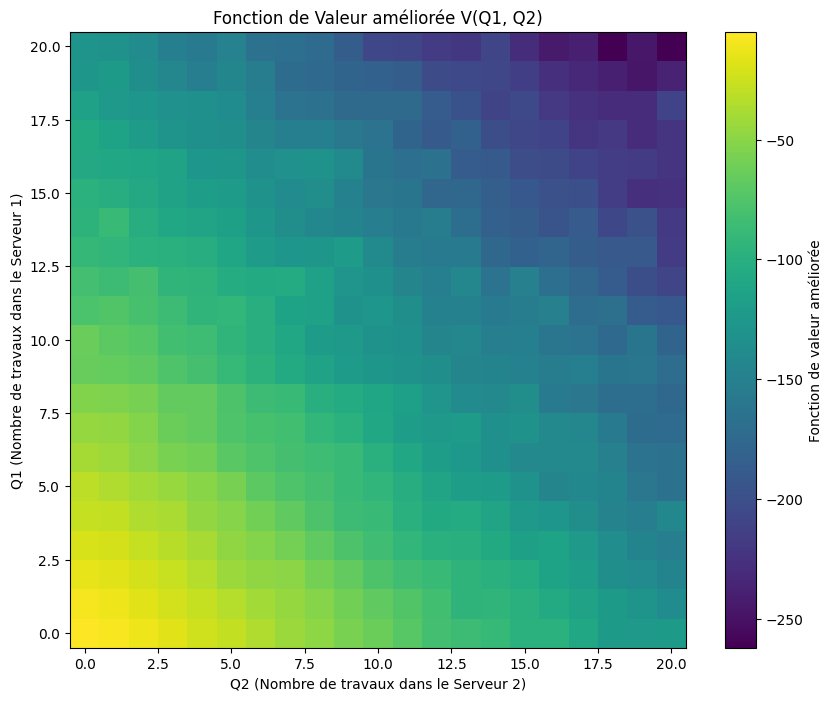

In [ ]:
improved_V = np.zeros((max_Q + 1, max_Q + 1))
alpha = 0.1

# Amélioration à un pas sur la politique aléatoire
for _ in range(30000):  # Nombre d'itérations pour l'apprentissage
    Q1 = np.random.randint(0, max_Q + 1)
    Q2 = np.random.randint(0, max_Q + 1)
    v1, v2 = 0, 0
    reward = -(Q1 + Q2)
    transitions_1 = next_state_prob_reward(Q1, Q2, 'a1')
    transitions_2 = next_state_prob_reward(Q1, Q2, 'a2')
    for prob, (new_Q1, new_Q2), _ in transitions_1:
        v1 += prob * improved_V[new_Q1, new_Q2]
    v1_target = reward + gamma * v1
    for prob, (new_Q1, new_Q2), _ in transitions_2:
        v2 += prob * improved_V[new_Q1, new_Q2]
    v2_target = reward + gamma * v2

    td_target = 0.5 * v1_target + 0.5 * v2_target
    td_error = td_target - improved_V[Q1, Q2]
    improved_V[Q1, Q2] += alpha * td_error

# Affichage de la fonction de valeur améliorée
plt.figure(figsize=(10, 8))
plt.imshow(improved_V, interpolation='nearest')
plt.colorbar(label='Fonction de valeur améliorée')
plt.title('Fonction de Valeur améliorée V(Q1, Q2)')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()

## 2 Tabular Model-Free control

### 2.1 Policy Evaluation

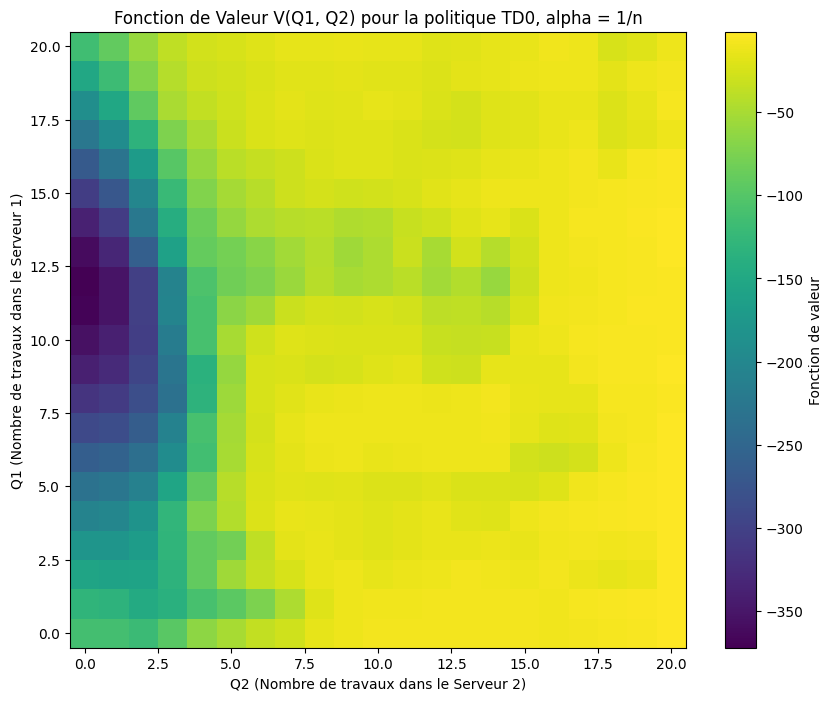

In [ ]:
class TD0_Servers(ServerEnvironment):
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20):
        super().__init__(mu1, mu2, lambd, max_jobs)
        self.state_values = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}
        self.state_visits = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}

    def learn(self, episodes, gamma=0.99):
        for episode in range(episodes):
            self.reset()
            state = (self.Q1, self.Q2)
            done = False

            while not done:
                action = random.choice(["a1", "a2"])
                next_state, reward, miss = self.step(action)
                self.state_visits[state] += 1
                alpha = 1 / (episode + 1)#1 / (episode + 1)**(1/2) #0.01

                # TD(0)
                self.state_values[state] += alpha * (reward + gamma * self.state_values[next_state] - self.state_values[state])

                if self.state_visits[state] > 1000:
                    done = True
                state = next_state


td0 = TD0_Servers()
td0.learn(100000)

V = np.zeros((td0.max_Q + 1, td0.max_Q + 1))
for state, value in td0.state_values.items():
    V[state[0], state[1]] = value

# Affichage de la fonction de valeur
plt.figure(figsize=(10, 8))
plt.imshow(V, interpolation='nearest')
plt.colorbar(label='Fonction de valeur')
plt.title('Fonction de Valeur V(Q1, Q2) pour la politique TD0, alpha = 1/n')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()


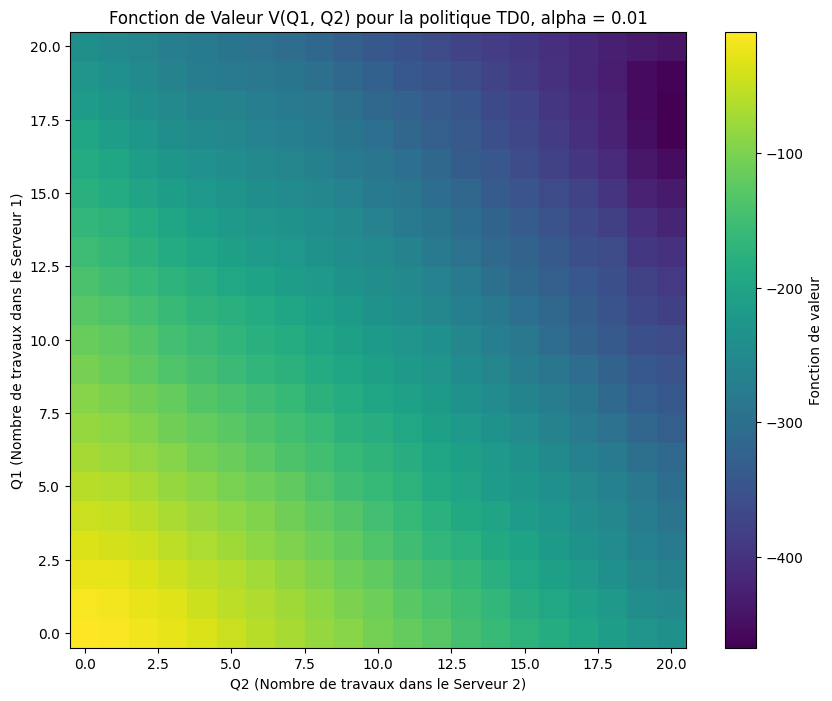

In [ ]:
class TD0_Servers(ServerEnvironment):
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20):
        super().__init__(mu1, mu2, lambd, max_jobs)
        self.state_values = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}
        self.state_visits = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}

    def learn(self, episodes, gamma=0.99):
        for episode in range(episodes):
            self.reset()
            state = (self.Q1, self.Q2)
            done = False

            while not done:
                action = random.choice(["a1", "a2"])
                next_state, reward, miss = self.step(action)
                self.state_visits[state] += 1
                alpha = 0.01

                # TD(0)
                self.state_values[state] += alpha * (reward + gamma * self.state_values[next_state] - self.state_values[state])

                if self.state_visits[state] > 1000:
                    done = True
                state = next_state


#Test de la class
td0 = TD0_Servers()
td0.learn(100000)

V = np.zeros((td0.max_Q + 1, td0.max_Q + 1))
for state, value in td0.state_values.items():
    V[state[0], state[1]] = value

# Affichage de la fonction de valeur
plt.figure(figsize=(10, 8))
plt.imshow(V, interpolation='nearest')
plt.colorbar(label='Fonction de valeur')
plt.title('Fonction de Valeur V(Q1, Q2) pour la politique TD0, alpha = 0.01')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()


### 2.2 Optimal control

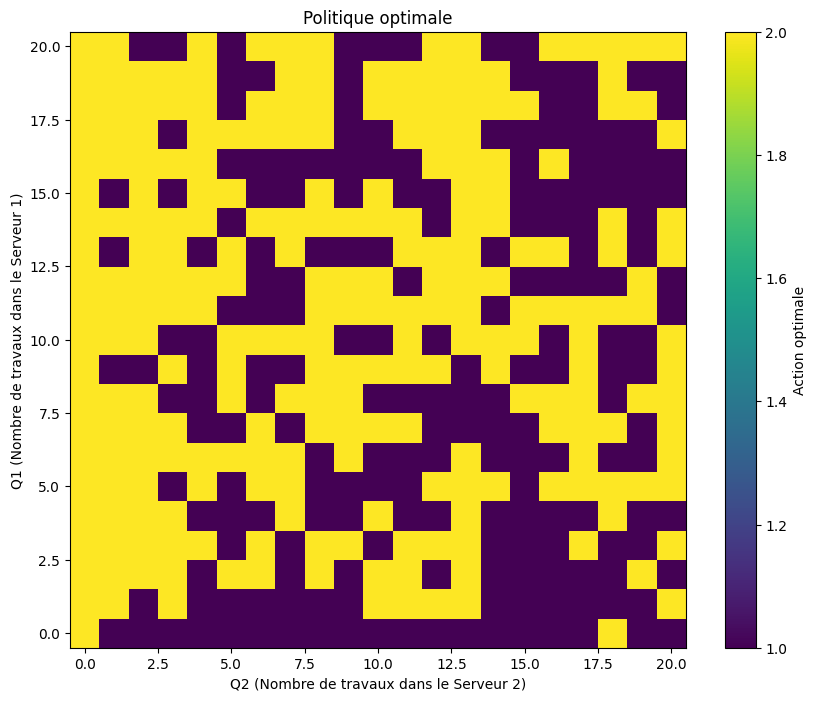

Nombre de jobs moyen :  1.36605
Nombre de jobs manqués moyen :  0.0


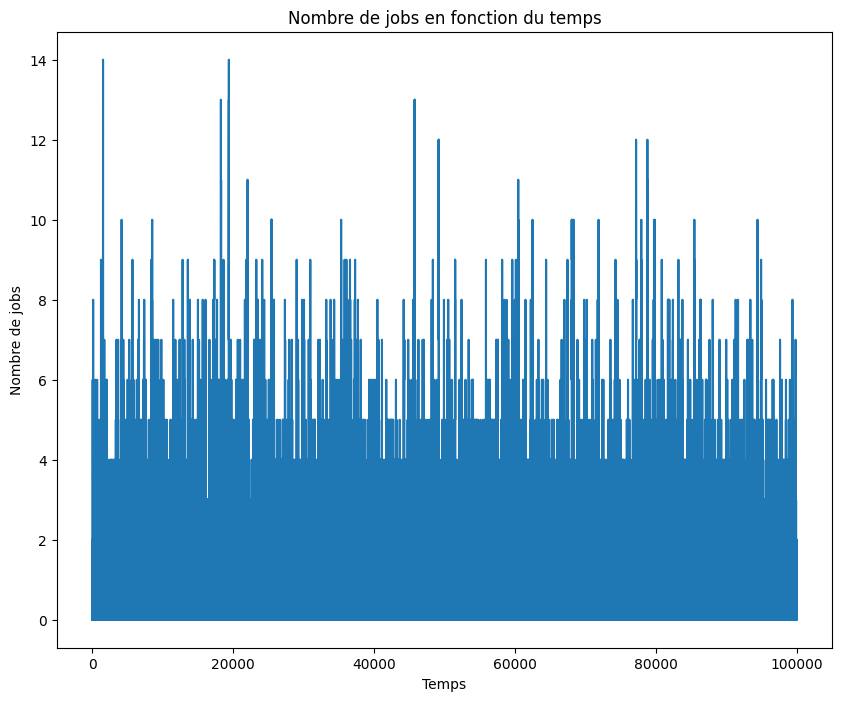

In [ ]:
#1ere implémentation de Q_Learning utilisant la politique epsilon greedy
class QLearningServers(ServerEnvironment):
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20):
        super().__init__(mu1, mu2, lambd, max_jobs)
        self.Q_table = {}
        self.visits = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}
        for i in range(max_jobs + 1):
            for j in range(max_jobs + 1):
                self.Q_table[(i, j)] = {'a1': 0, 'a2': 0}


    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.choice(['a1', 'a2'])
        else:
            return max(self.Q_table[state], key=self.Q_table[state].get)

    def learn(self, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
        for episode in range(episodes):
            self.reset()
            state = (self.Q1, self.Q2)
            done = False

            while not done:
                action = self.choose_action(state, epsilon)
                next_state, reward = self.step(action)

                # Q-learning
                best_next_action = max(self.Q_table[next_state], key=self.Q_table[next_state].get)
                self.Q_table[state][action] += alpha * (reward + gamma * self.Q_table[next_state][best_next_action] - self.Q_table[state][action])

                self.visits[state] += 1

                state = next_state

                if  self.visits[state] > 1000:
                    done = True

import math
import random
# 2ème implémentation avec la politique UCB
class UCB_QLearningServers(QLearningServers):
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20, c=1.0):
        super().__init__(mu1, mu2, lambd, max_jobs)
        self.action_counts = {(i, j): {'a1': 0, 'a2': 0} for i in range(max_jobs + 1) for j in range(max_jobs + 1)}
        self.state_visits = {(i, j): 0 for i in range(max_jobs + 1) for j in range(max_jobs + 1)}
        self.c = c

    def choose_action(self, state):
        self.state_visits[state] += 1
        total_visits = self.state_visits[state]

        ucb_values = {}
        for action in self.Q_table[state]:
            action_count = self.action_counts[state][action]
            if action_count == 0:
                ucb_values[action] = float('inf')
            else:
                exploration = self.c * math.sqrt(math.log(total_visits) / action_count)
                ucb_values[action] = self.Q_table[state][action] + exploration

        return max(ucb_values, key=ucb_values.get)

    def learn(self, episodes, alpha=0.1, gamma=0.9):
        for episode in range(episodes):
            self.reset()
            state = (self.Q1, self.Q2)
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, miss = self.step(action)

                self.action_counts[state][action] += 1

                # Q-Learning
                best_next_action = max(self.Q_table[next_state], key=self.Q_table[next_state].get)
                self.Q_table[state][action] += alpha * (reward + gamma * self.Q_table[next_state][best_next_action] - self.Q_table[state][action])

                state = next_state

                if self.action_counts[state][action] > 1000:
                    done = True



# Entraînement avec la politique UCB
q_learning_model = UCB_QLearningServers()
q_learning_model.learn(episodes=100000)

# Recuperation des actions optimales de UCB
Q_table = q_learning_model.Q_table
optimal_actions = np.zeros((21, 21))
for i in range(21):
    for j in range(21):
        action = max(Q_table[(i, j)], key=Q_table[(i, j)].get)
        if action == 'a1':
            optimal_actions[i, j] = 1
        else:
            optimal_actions[i, j] = 2

plt.figure(figsize=(10, 8))
plt.imshow(optimal_actions, interpolation='nearest')
plt.colorbar(label='Action optimale')
plt.title('Politique optimale')
plt.xlabel('Q2 (Nombre de travaux dans le Serveur 2)')
plt.ylabel('Q1 (Nombre de travaux dans le Serveur 1)')
plt.gca().invert_yaxis()  # Inversion de l'axe des ordonnées
plt.show()


# Initialiser l'environnement
env = ServerEnvironment()

# Comparaison des politiques
nb_episodes = 100000
comtpeur = 0

nb_jobs = 0
nb_jobs_miss = 0

jobs = []

while comtpeur < nb_episodes:
    action = optimal_actions[env.Q1, env.Q2]
    if action == 1.0:
        action = 'a1'
    elif action == 2.0:
        action = 'a2'
    #Action random entre 'a1' et 'a2'
    #action  = 'a1' if random.random() < 0.5 else 'a2'
    (new_Q1, new_Q2), reward, miss = env.step(action)
    nb_jobs = new_Q1 + new_Q2
    jobs.append(nb_jobs)
    comtpeur += 1

print("Nombre de jobs moyen : ", np.mean(jobs))
print("Nombre de jobs manqués moyen : ", nb_jobs_miss / nb_episodes)

#Plot des jobs
plt.figure(figsize=(10, 8))
plt.plot(jobs)
plt.title('Nombre de jobs en fonction du temps')
plt.xlabel('Temps')
plt.ylabel('Nombre de jobs')
plt.show()

## 3 Model-free control with Value Function/Policy approximation

In [ ]:
#Creation d'un nouvel environnement pour le server où le reset remet Q1 et Q2 à zéro
class ServerEnvironment:
    def __init__(self, mu1=0.2, mu2=0.4, lambd=0.3, max_jobs=20):
        self.mu1 = mu1
        self.mu2 = mu2
        self.lbda = lambd
        self.max_Q = max_jobs
        self.Q1 = 0
        self.Q2 = 0

    def reset(self):
        self.Q1 = 0
        self.Q2 = 0

    def get_state(self):
        return (self.Q1, self.Q2)

    def step(self, action):
        crit = random.random()
        miss = False

        if crit < self.mu1:  # Départ dans Q1
            new_Q1 = max(0, self.Q1 - 1)
            new_Q2 = self.Q2
        elif (crit >= self.mu1) and (crit < self.mu1 + self.mu2):  # Départ dans Q2
            new_Q1 = self.Q1
            new_Q2 = max(0, self.Q2 - 1)
        elif (crit >= self.mu1 + self.mu2) and (crit < self.mu1 + self.mu2 + self.lbda):
            if self.Q1 == self.max_Q and self.Q2 == self.max_Q:
                miss = True
            if not (self.Q1 == self.max_Q and self.Q2 == self.max_Q):
                if self.Q1 == self.max_Q :
                    new_Q1 = self.Q1
                    new_Q2 = self.Q2 + 1
                elif self.Q2 == self.max_Q :
                    new_Q1 = self.Q1 + 1
                    new_Q2 = self.Q2
                else:
                    if action == 'a1':
                        new_Q1 = self.Q1 + 1
                        new_Q2 = self.Q2
                    elif action == 'a2':
                        new_Q1 = self.Q1
                        new_Q2 = self.Q2 + 1
            else :
                new_Q1 = self.Q1
                new_Q2 = self.Q2
        else:  # Reste dans le même état
            new_Q1 = self.Q1
            new_Q2 = self.Q2

        self.Q1 = new_Q1
        self.Q2 = new_Q2
        reward = -(self.Q1 + self.Q2)

        return (self.Q1, self.Q2), reward, miss


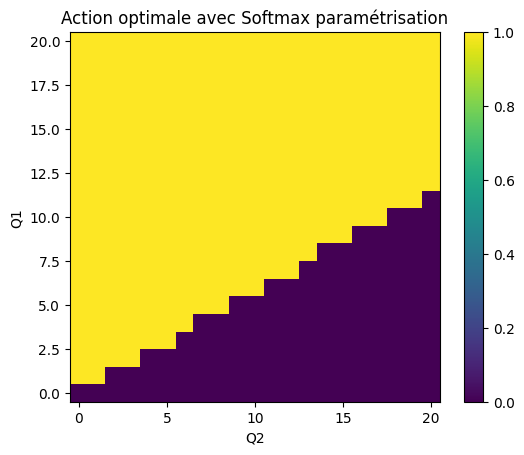

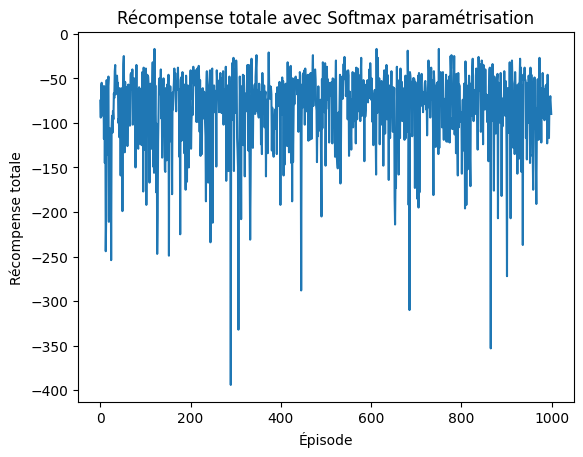

In [ ]:
# Hyperparamètres
learning_rate = 0.001
gamma = 0.99
num_episodes = 1000

# Créer l'environnement
env = ServerEnvironment()

# Paramètres de la politique
theta = np.zeros((2,2))  # 2 états (Q1, Q2) et 2 actions

# Softmax policy
def softmax_policy(state, theta):
    z = np.dot(state, theta)
    exp = np.exp(z)
    return exp / np.sum(exp)

# Générer un épisode
def generate_episode(env, theta):
    states, actions, rewards = [], [], []
    env.reset()
    state = env.get_state()
    done = 60
    compteur = 0
    while compteur <= done:
        state_vector = np.array([state[0], state[1]])
        probs = softmax_policy(state_vector, theta)
        action = np.random.choice([0, 1], p=probs)  # 0 pour 'a1', 1 pour 'a2'
        next_state, reward, miss = env.step(['a1', 'a2'][action])
        states.append(state_vector)
        actions.append(action)
        rewards.append(reward)
        state = np.array([next_state[0], next_state[1]])
        compteur += 1
    return states, actions, rewards

# Mise à jour de la politique
def update_policy(theta, states, actions, rewards):
    G = 0
    returns = np.zeros_like(rewards)
    for t in reversed(range(len(rewards))):
        G = gamma * G + rewards[t]
        returns[t] = G

    for state, action, G in zip(states, actions, returns):
        probs = softmax_policy(state, theta)
        dsoftmax = probs.copy()
        dsoftmax[action] -= 1
        dtheta = np.outer(state, dsoftmax)
        theta += learning_rate * G * dtheta
    return theta

list_total_reward = []
# Boucle d'entraînement
for episode in range(num_episodes):
    states, actions, rewards = generate_episode(env, theta)
    theta = update_policy(theta, states, actions, rewards)
    total_reward = sum(rewards)
    list_total_reward.append(total_reward)
    #if episode % 100 == 0:
        #print(f"Épisode {episode}: Récompense totale = {total_reward}")


# Recuperation des actions optimales
optimal_actions = np.zeros((21, 21))
for i in range(21):
    for j in range(21):
        state = np.array([i, j])
        probs = softmax_policy(state, theta)
        optimal_actions[i, j] = np.argmax(probs)
plt.imshow(optimal_actions)
plt.title("Action optimale avec Softmax paramétrisation")
plt.xlabel('Q2')
plt.ylabel('Q1')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

# Afficher la récompense totale par épisode d'entraînement
plt.plot(list_total_reward)
plt.title("Récompense totale avec Softmax paramétrisation")
plt.xlabel('Épisode')
plt.ylabel('Récompense totale')
plt.show()